In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load and prepare data
data = pd.read_csv("ner_dataset.csv", encoding="latin1").ffill()
words = list(data["Word"].unique())
tags = list(data["Tag"].unique())

if "ENDPAD" not in words:
    words.append("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

```
Thanjiyappan K
212222240108
```

In [6]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [7]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35177
Unique tags in corpus: 17


In [8]:
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [9]:
# Group words by sentences
class SentenceGetter:
    def __init__(self, data):
        self.grouped = data.groupby("Sentence #", group_keys=False).apply(
            lambda s: [(w, t) for w, t in zip(s["Word"], s["Tag"])]
        )
        self.sentences = list(self.grouped)

getter = SentenceGetter(data)
sentences = getter.sentences


```
Thanjiyappan K
212222240108
```

In [10]:
sentences[35]

[('The', 'O'),
 ('U.S.', 'B-org'),
 ('Geological', 'I-org'),
 ('Survey', 'I-org'),
 ('gave', 'O'),
 ('a', 'O'),
 ('preliminary', 'O'),
 ('estimate', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('strength', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Tuesday', 'B-tim'),
 ('morning', 'I-tim'),
 ('quake', 'O'),
 ('at', 'O'),
 ('6.7', 'O'),
 ('on', 'O'),
 ('the', 'O'),
 ('Richter', 'B-geo'),
 ('scale', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('said', 'O'),
 ('the', 'O'),
 ('epicenter', 'O'),
 ('was', 'O'),
 ('close', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 ('of', 'O'),
 ('Nias', 'B-org'),
 ('.', 'O')]

In [11]:
# Encode sentences
X = [[word2idx[w] for w, t in s] for s in sentences]
y = [[tag2idx[t] for w, t in s] for s in sentences]

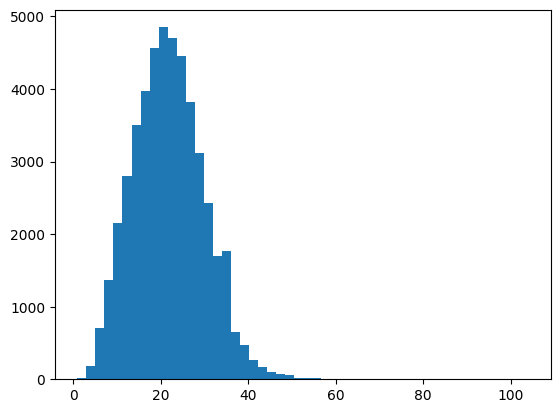

In [13]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

```
Thanjiyappan K
212222240108
```

In [14]:
# Pad sequences
max_len = 50
X_pad = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True, padding_value=word2idx["ENDPAD"])
y_pad = pad_sequence([torch.tensor(seq) for seq in y], batch_first=True, padding_value=tag2idx["O"])
X_pad = X_pad[:, :max_len]
y_pad = y_pad[:, :max_len]

In [15]:
X_pad[0]

tensor([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    12,    13,    14,    15,    10,    16,     2,    17,    18,
           19,    20,    21,    22, 35178, 35178, 35178, 35178, 35178, 35178,
        35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
        35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178])

In [16]:
y_pad[0]

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

```
Thanjiyappan K
212222240108
```

In [17]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=0.2, random_state=1)

In [18]:
# Dataset class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "input_ids": self.X[idx],
            "labels": self.y[idx]
        }

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(NERDataset(X_test, y_test), batch_size=32)
